In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



d:\Flower_image_Classification


In [2]:
from libs.common import *
from config.config import *
from utils.utils import load_data, flower_labels, view_hist_data,view_images
import matplotlib.pyplot as plt

d:/Flower_image_Classification


In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import tensorflow as tf

# # Kiểm tra lại xem GPU đã được tắt
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Kiểm tra thiết bị được sử dụng (sẽ không có tên GPU nếu không sử dụng)
# print("Device Name: ", tf.test.gpu_device_name())


In [4]:
# import tensorflow as tf

# # Cấu hình TensorFlow để sử dụng GPU
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# # Kiểm tra lại GPU đã nhận diện
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Kiểm tra tên của GPU được sử dụng (nếu có)
# print("GPU Device Name: ", tf.test.gpu_device_name())


In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
# data_dir="../../data"
# exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [7]:
from config.config import *
from utils.utils import processing_data

# csv_path = os.path.join(dataset_dir, "fer2013", "fer2013.csv")
# output_dir = os.path.join(data_dir, "preprocessing")
# processing_data(csv_path, output_dir)

In [8]:
from config.config import *
from utils.utils import load_data, flower_labels, view_hist_data,view_images, boxPlot
import matplotlib.pyplot as plt
from models.models import VGG16, RESNET50, build_common_model
from tensorflow.keras import backend as K
# K.set_image_data_format('channels_last')



In [9]:
train_path = os.path.join(data_dir, "train.csv").replace("\\", "/")
test_path = os.path.join(data_dir, "val.csv").replace("\\", "/")
# test_path = os.path.join(data_dir, "preprocessing", "test.npz")
print(train_path)

d:/Flower_image_Classification/data/train.csv


In [10]:
(x_train, y_train), (x_test, y_test)= load_data(train_path, test_path)

Read train data:  d:/Flower_image_Classification/data/train.csv
['train/carnation/6838762136_f8254d6a1a_c.jpg'
 'train/carnation/3540544866_823aee81af_c.jpg'
 'train/carnation/50034862576_b0f55b7b3b_c.jpg' ...
 'train/common_daisy/26267498316_8ed1c153b4_c.jpg'
 'train/common_daisy/50560319813_debdfea05e_c.jpg'
 'train/common_daisy/7462259536_7f096c222f_c.jpg']
Read valid data:  d:/Flower_image_Classification/data/val.csv


train/carnation/6838762136_f8254d6a1a_c.jpg
Training images:  13642  - shape:  (256, 256, 3)
Validating images:  98  - shape:  (256, 256, 3)


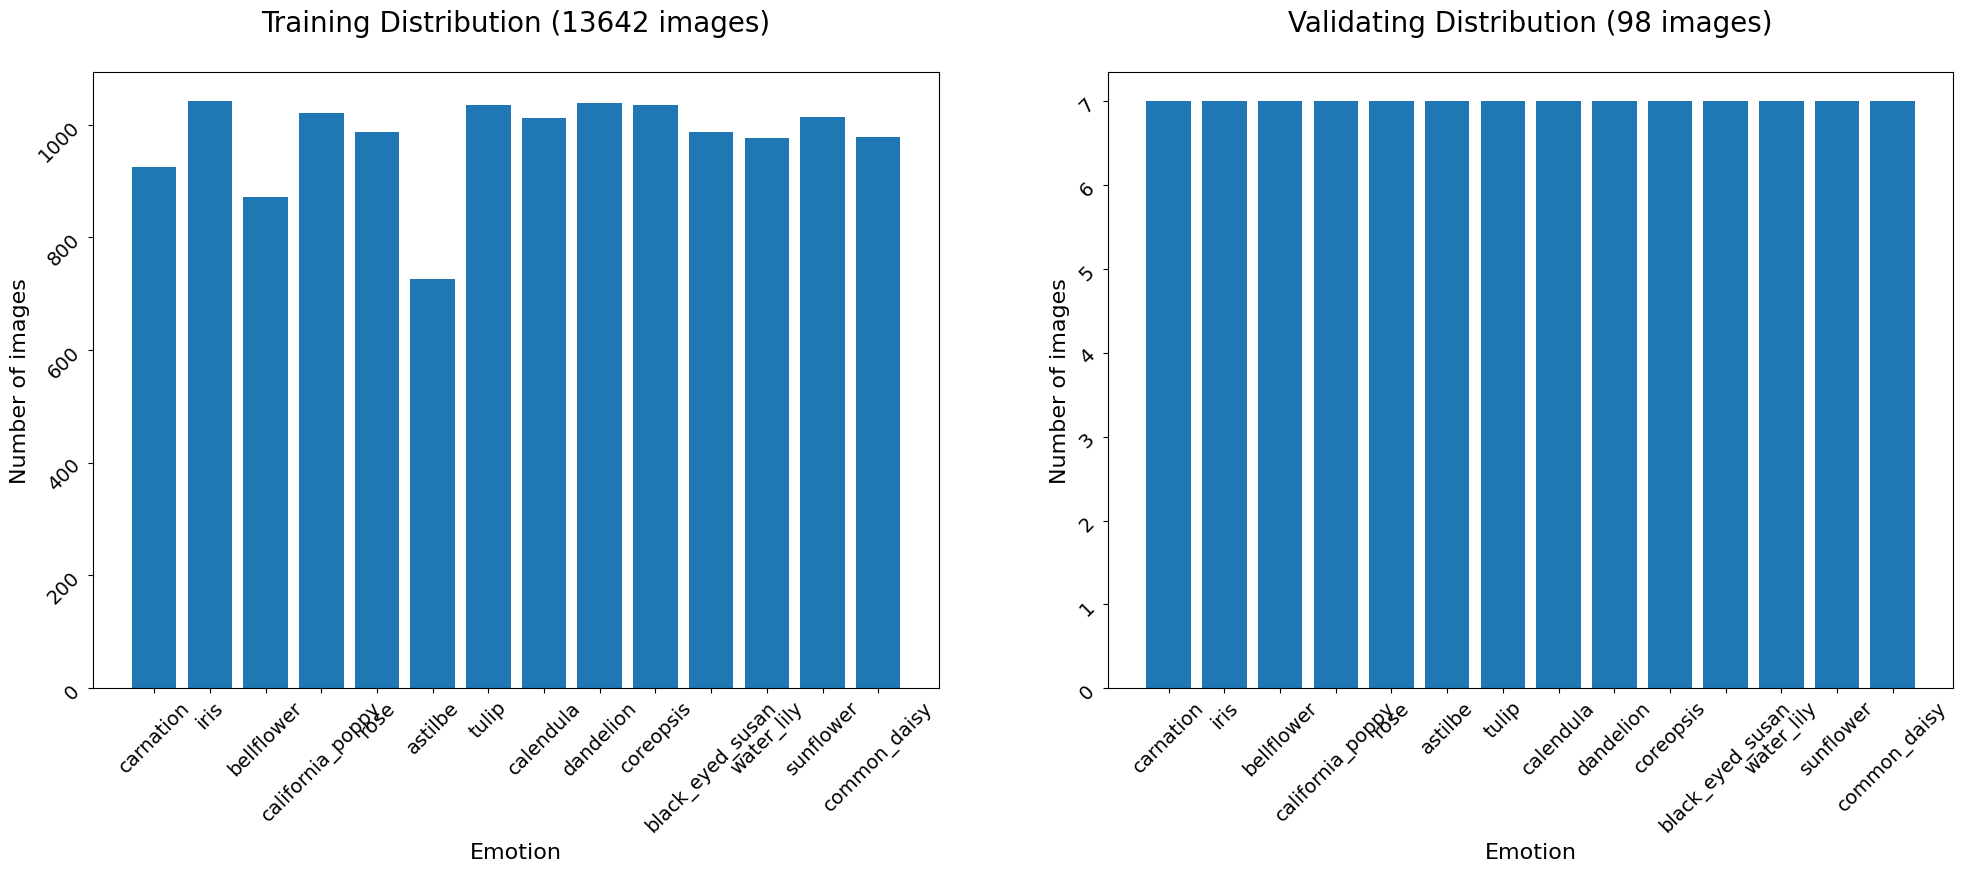

In [11]:
view_hist_data(x_train, y_train, x_test, y_test, save_path = f'{save_dir}/distribution.png')

Sample training images


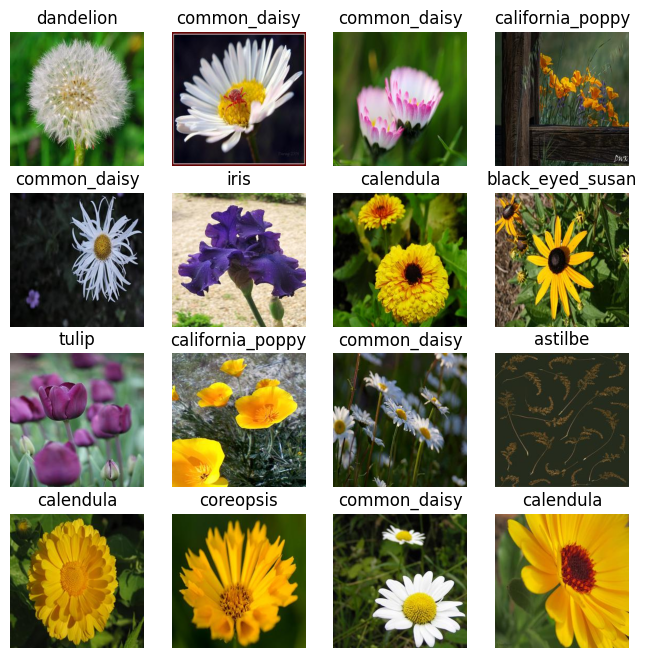

Sample Test images


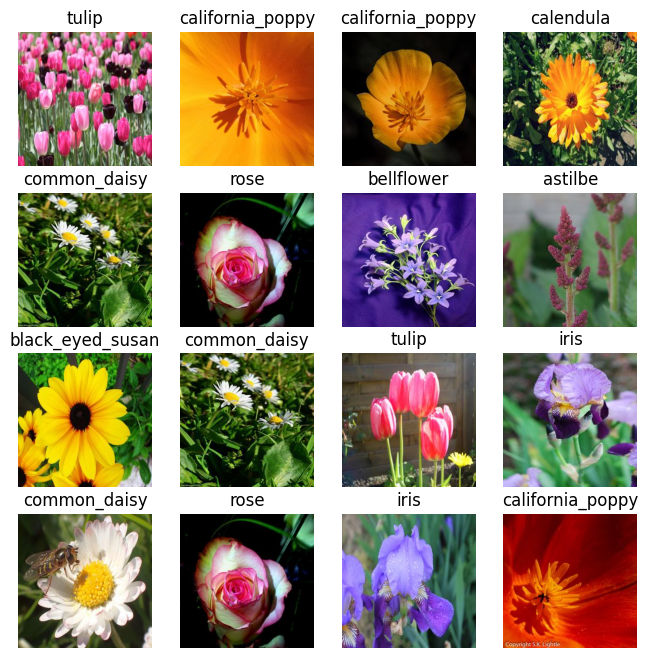

In [12]:
print("Sample training images")
view_images(x_train, y_train, None, rows = 4, cols = 4, figsize = (8, 8), 
            save_path = f'{save_dir}/sample_training_images.png')

print("Sample Test images")
view_images(x_test, y_test, None, rows = 4, cols = 4, figsize = (8, 8), 
            save_path = f'{save_dir}/sample_validating_images.png')



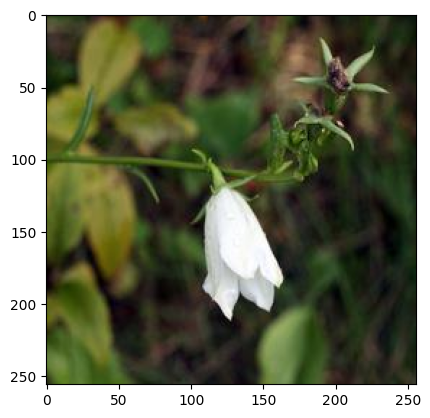

In [13]:
flow1 = cv2.imread(f'{data_dir}/train/bellflower/48917780_834f0a1ce3_c.jpg')
flow1 = cv2.cvtColor(flow1,cv2.COLOR_BGR2RGB)
plt.imshow(flow1)

In [14]:
image_gen = ImageDataGenerator(rotation_range=30, 
                               width_shift_range=0.1,
                               height_shift_range=0.1, 
                               rescale=1/255, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               fill_mode='nearest', 
                               validation_split=0.2
                              )

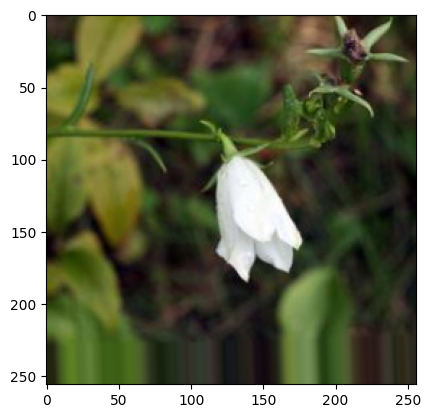

In [15]:
plt.imshow(image_gen.random_transform(flow1))

In [16]:
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(f'{data_dir}/train',
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='training')

Found 10919 images belonging to 14 classes.


In [17]:
valid_image_gen = image_gen.flow_from_directory(f'{data_dir}/train',
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='validation')

Found 2723 images belonging to 14 classes.


In [18]:
train_image_gen.class_indices

{'astilbe': 0,
 'bellflower': 1,
 'black_eyed_susan': 2,
 'calendula': 3,
 'california_poppy': 4,
 'carnation': 5,
 'common_daisy': 6,
 'coreopsis': 7,
 'dandelion': 8,
 'iris': 9,
 'rose': 10,
 'sunflower': 11,
 'tulip': 12,
 'water_lily': 13}

In [19]:
current_class_indices = train_image_gen.class_indices

desired_order = ["carnation", "iris", "bellflower", "california_poppy", "rose", "astilbe", 
                 "tulip", "calendula", "dandelion", "coreopsis", "black_eyed_susan", 
                 "water_lily", "sunflower", "common_daisy"]

sorted_class_indices = {}
for idx, label in enumerate(desired_order):
    if label in current_class_indices:
        sorted_class_indices[label] = idx

train_image_gen.class_indices = sorted_class_indices
valid_image_gen.class_indices = sorted_class_indices
print(train_image_gen.class_indices)
print(valid_image_gen.class_indices)


{'carnation': 0, 'iris': 1, 'bellflower': 2, 'california_poppy': 3, 'rose': 4, 'astilbe': 5, 'tulip': 6, 'calendula': 7, 'dandelion': 8, 'coreopsis': 9, 'black_eyed_susan': 10, 'water_lily': 11, 'sunflower': 12, 'common_daisy': 13}
{'carnation': 0, 'iris': 1, 'bellflower': 2, 'california_poppy': 3, 'rose': 4, 'astilbe': 5, 'tulip': 6, 'calendula': 7, 'dandelion': 8, 'coreopsis': 9, 'black_eyed_susan': 10, 'water_lily': 11, 'sunflower': 12, 'common_daisy': 13}


In [20]:
# Get a batch from the DirectoryIterator
batch_images, batch_labels = next(train_image_gen)
valid_images,valid_labels=next(valid_image_gen)

# Check the shape of the batch
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

Batch images shape: (64, 224, 224, 3)
Batch labels shape: (64, 14)


In [21]:
# Assuming you have your input data ready
train_steps = 100000//batch_size
valid_steps = 20000//batch_size

input_data_resnet = batch_images  # shape: (num_samples, 224, 224, 3)
input_data_vgg = batch_images     # shape: (num_samples, 224, 224, 3)
target_data = batch_labels 


valid_data_resnet=valid_images
valid_data_vgg=valid_images
valid_target_data =valid_labels# 

In [22]:
print(batch_labels)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0.

In [23]:
unique_classes = np.array(np.unique(train_image_gen.classes))
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=train_image_gen.classes)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
np.savez(f'{save_dir}/class_weights_dict.npz', class_weights_dict = class_weights_dict)
class_weights_dict

{0: 1.342389968035407,
 1: 1.1173761768317643,
 2: 0.9885026253847546,
 3: 0.9640649832244393,
 4: 0.954624934429096,
 5: 1.053957528957529,
 6: 0.9960773581463237,
 7: 0.9419427191166322,
 8: 0.9385422038851642,
 9: 0.9362888012347796,
 10: 0.9885026253847546,
 11: 0.9616875110093359,
 12: 0.9419427191166322,
 13: 0.997351114358787}

In [25]:
early_stopping = EarlyStopping(monitor='val_loss',
    # min_delta=0.00005,
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.95,
    patience=2,
    min_lr=0.000001,
    verbose=1,
)

os.makedirs('weights', exist_ok=True)

checkpoint_filepath = 'weights/checkpoint.weights.h5'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [26]:
vgg16 = build_common_model(model_name="imagenet_vgg16")
vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 14)             │        28,672 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 15,793,984 (60.25 MB)

 Trainable params: 15,793,984 (60.25 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
lr=0.0001
vgg16.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
starting_time = time.time()
history_vgg16 = vgg16.fit(
    train_image_gen,
    epochs=10,
    batch_size=64,
    validation_data=valid_image_gen,
    validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/10


c:\Users\Admin\miniconda3\envs\aidu_prj\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.1292 - loss: 2.4004 

c:\Users\Admin\miniconda3\envs\aidu_prj\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


171/171 ━━━━━━━━━━━━━━━━━━━━ 3745s 22s/step - accuracy: 0.1294 - loss: 2.3996 - val_accuracy: 0.1943 - val_loss: 2.0981 - learning_rate: 1.0000e-04
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3921s 23s/step - accuracy: 0.2057 - loss: 2.0741 - val_accuracy: 0.3125 - val_loss: 1.7919 - learning_rate: 1.0000e-04
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3788s 22s/step - accuracy: 0.3240 - loss: 1.7774 - val_accuracy: 0.4029 - val_loss: 1.6306 - learning_rate: 1.0000e-04
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3812s 22s/step - accuracy: 0.3861 - loss: 1.6195 - val_accuracy: 0.4231 - val_loss: 1.5632 - learning_rate: 1.0000e-04
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3829s 22s/step - accuracy: 0.4276 - loss: 1.5272 - val_accuracy: 0.4682 - val_loss: 1.4322 - learning_rate: 1.0000e-04
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3842s 22s/step - accuracy: 0.4750 - loss: 1.4228 - val_accuracy: 0.5068 - val_loss: 1.3586 - learning_rate: 1.0000e-04
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3860s 23s/step - 

KeyboardInterrupt: 

In [ ]:
Inceptionv3 = build_common_model(model_name="imagenet_inception_v3")
Inceptionv3.summary()

In [ ]:
lr=0.0001
Inceptionv3.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
starting_time = time.time()
history_inception = Inceptionv3.fit(
    train_image_gen,
    epochs=10,
    batch_size=64,
    validation_data=valid_image_gen,
    validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
Resnet = build_common_model(model_name="imagenet_resnet50")
Resnet.summary()

In [ ]:
lr=0.0001
starting_time = time.time()
Resnet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet = Resnet.fit(
    train_image_gen,
    epochs=10,
    batch_size=64,
    validation_data=valid_image_gen,
    validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
MobileNet = build_common_model(model_name="imagenet_mobileNetv3")
MobileNet.summary()

In [ ]:
lr=0.0001
starting_time = time.time()
MobileNet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet = MobileNet.fit(
    train_image_gen,
    epochs=10,
    batch_size=64,
    validation_data=valid_image_gen,
    validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
DenseNet = build_common_model(model_name="imagenet_densenet")
DenseNet.summary()

In [ ]:
lr=0.0001
starting_time = time.time()
DenseNet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
history_densent = DenseNet.fit(
    train_image_gen,
    epochs=10,
    batch_size=64,
    validation_data=valid_image_gen,
    validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
accuracy=[vgg16.history.history['accuracy'],Resnet.history.history['accuracy'],Inceptionv3.history.history['accuracy'],MobileNet.history.history['accuracy'],DenseNet.history.history['accuracy']]
name_models=['VGG16', 'ResNet','InceptionV3', 'MobileNet', 'DenseNet']

In [ ]:
boxPlot(accuracy,name_models)